# SVM(Support Vector Machine)
***
kNN 알고리즘은 주변의 가까운 사람들에게 물어봐서 대다수의 답변과 동일하게 답변하는 방법이다. 만약 3명에게 물어봤을 때 2명이 거짓으로 대답한다면 예측은 틀리게 된다.
서포트 벡터 머신은 '지금 현재 이곳이 한강의 북쪽인지, 남쪽인지?'와 같이 질문해서 답변을 얻는 방법이다.<br/>
서포트 벡터라는 개념은 한강의 위치를 찾는데 사용되는 개념으로 한강은 도시가 강북인지 강남인지 구분하는 결정 경계선(Decision Boundary)이다.
서포트 벡터는 결정 경계선을 찾는데 사용되는 개념이고 벡터는 2차원 공간 상에 나타나는 데이터 포인트를 의미한다.
따라서, 서포트 벡터는 결정 경계선과 가장 가까이 맞닿은 데이터 포인트를 의미한다.<br/>
서포트 벡터와 결정 경계선 사이의 거리를 마진이라 하고 서포트 벡터 머신의 목표는 마진을 최대로 하는 결정 경계를 찾는 것이다.
서포트 벡터 머신에서는 약간의 오류를 허용하기 위해 비용(C)이라는 변수를 사용한다.
비용이 낮을수록 마진을 최대한 높이고 학습 에러율은 증가, 비용이 높을수록 마진은 낮아지고 학습 에러율은 감소하는 방향으로 결정 경계를 만든다.
비용이 너무 낮으면 과소 적합, 높으면 과대 적합의 위험이 있으니 적절한 비용값을 찾는 과정이 중요하다.

In [31]:
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [32]:
# 최적의 비용과 감마값을 찾기 위해 GridSearchCV() 메서드를 import 한다.
from sklearn.model_selection import GridSearchCV
# SVM 알고리즘을 사용하기 위해 SVC() 메서드를 import 한다. SVC: Support Vector Classification
from sklearn.svm import SVC
# 분류 결과 정확도, 정밀도, 재현율, F1 점수 리포트를 출력하기 위해 classification_report() 메서드를 import 한다.
from sklearn.metrics import classification_report

In [33]:
df = pd.read_csv('./data/basketball_stat.csv')
print(type(df))
df.drop(['2P', 'AST', 'STL'], axis=1, inplace=True)
train, test = train_test_split(df, test_size=0.2)
df.head()

<class 'pandas.core.frame.DataFrame'>


,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5


# 커널 트릭(Kernel Trick)
***
저차원 벡터 공간의 데이터를 고차원 벡터 공간으로 옮겨줌으로써 결정 경계를 찾는 방법이다.
저차원의 데이터를 고차원의 데이터로 옮겨주는 함수를 매핑 함수(Mapping Function)라 하고, 매핑 함수로 많은 양의 데이터를 고차원으로 옮기기에 연산량이 너무 많아져서 현실적으로 사용하기 어렵다.
실제로 데이터를 고차원으로 보내지는 않지만 보낸 것과 동일한 효과를 줘서 빠른 속도로 결정 경계를 찾는 방법이 고안되었으며 이를 <strong>커널 트릭</strong>이라 한다.

최적의 파라미터 찾기
SVM에서 RBF(가우시안) 커널을 사용하므로 마진의 너비를 조정하는 파라미터(C)와 결정 경계선의 곡률을 조정하는 파라미터(Gamma)를 알아내야 한다.
scikit-learn의 Grid Search를 개발자가 부여한 비용과 감마의 후보들을 조합해서 최적의 비용과 감마값을 알아낸다.

In [34]:
# scikit-learn에서 제공하는 GraidSearchCV() 메서드를 사용해서 최적의 비용과 감마값을 알아내는 함수
def svm_param_selection(x, y, nfold):
    # 비용과 감마값의 후보를 정한다.
    svm_parameters = [
        {'kernel': ['rbf'], 'gamma': [0.00001, 0.0001, 0.001, 0.01, 1], 'C': [0.01, 0.1, 1, 10, 100, 1000]}
    ]
    clf = GridSearchCV(SVC(), svm_parameters, cv=nfold)  # GridSearchCV 객체를 만든다.
    clf.fit(x, y.values.ravel())  # GridSearchCV를 학습시킨다.
    print(clf.best_score_)  # 최고 점수
    print(clf.best_params_)  # 최고 점수를 낸 파라미터
    print(clf.best_estimator_)  # 최고 점수를 낸 파라미터를 가진 SVC 객체 모델
    return clf

In [35]:
x_train = train[['3P', 'BLK']]  # 3점슛과 블로킹 횟수를 학습 데이터로 지정한다.
y_train = train['Pos']  # 포지션을 실제값으로 지정한다.
clf = svm_param_selection(x_train, y_train, 10)

0.95
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=1, gamma=1)


결정 경계 시각화

In [36]:
# 최고 점수를 낸 파라미터를 이용해서 시각화 할 비용 후보들을 저장한다.
C_candidates = []
C_candidates.append(clf.best_params_['C'] * 0.01)
C_candidates.append(clf.best_params_['C'])  # 최적의 'C' 값
C_candidates.append(clf.best_params_['C'] * 100)
print(C_candidates)

# 최고 점수를 낸 파라미터를 이용해서 시각화 할 감마 후보들을 저장한다.
gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma'] * 0.01)
gamma_candidates.append(clf.best_params_['gamma'])  # 최적의 'gamma' 값
gamma_candidates.append(clf.best_params_['gamma'] * 100)
print(gamma_candidates)

[0.01, 1, 100]
[0.01, 1, 100]


시각화를 위해 포지션(센터: C = 0, 슈팅가드: SG = 1)을 숫자로 표현한다.

In [37]:
position = []
for i in y_train:
    if i == 'C':
        position.append(0)
    else:
        position.append(1)
print(position)

[1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]


최적의 파라미터 후보들을 조합해서 학습한 모델들을 저장한다.

In [38]:
classifiers = []
for C in C_candidates:
    for gamma in gamma_candidates:
        clf = SVC(C=C, gamma=gamma)  # 최적의 파라미터 후보들을 조합해서 서포트 벡터 머신 모델을 만든다.
        clf.fit(x_train, y_train)  # 최적의 파라미터 후보들을 조합해서 서포트 벡터 머신 모델을 학습시킨다.
        classifiers.append([C, gamma, clf])
classifiers

[[0.01, 0.01, SVC(C=0.01, gamma=0.01)],
 [0.01, 1, SVC(C=0.01, gamma=1)],
 [0.01, 100, SVC(C=0.01, gamma=100)],
 [1, 0.01, SVC(C=1, gamma=0.01)],
 [1, 1, SVC(C=1, gamma=1)],
 [1, 100, SVC(C=1, gamma=100)],
 [100, 0.01, SVC(C=100, gamma=0.01)],
 [100, 1, SVC(C=100, gamma=1)],
 [100, 100, SVC(C=100, gamma=100)]]

각 모델을 시각화한다.

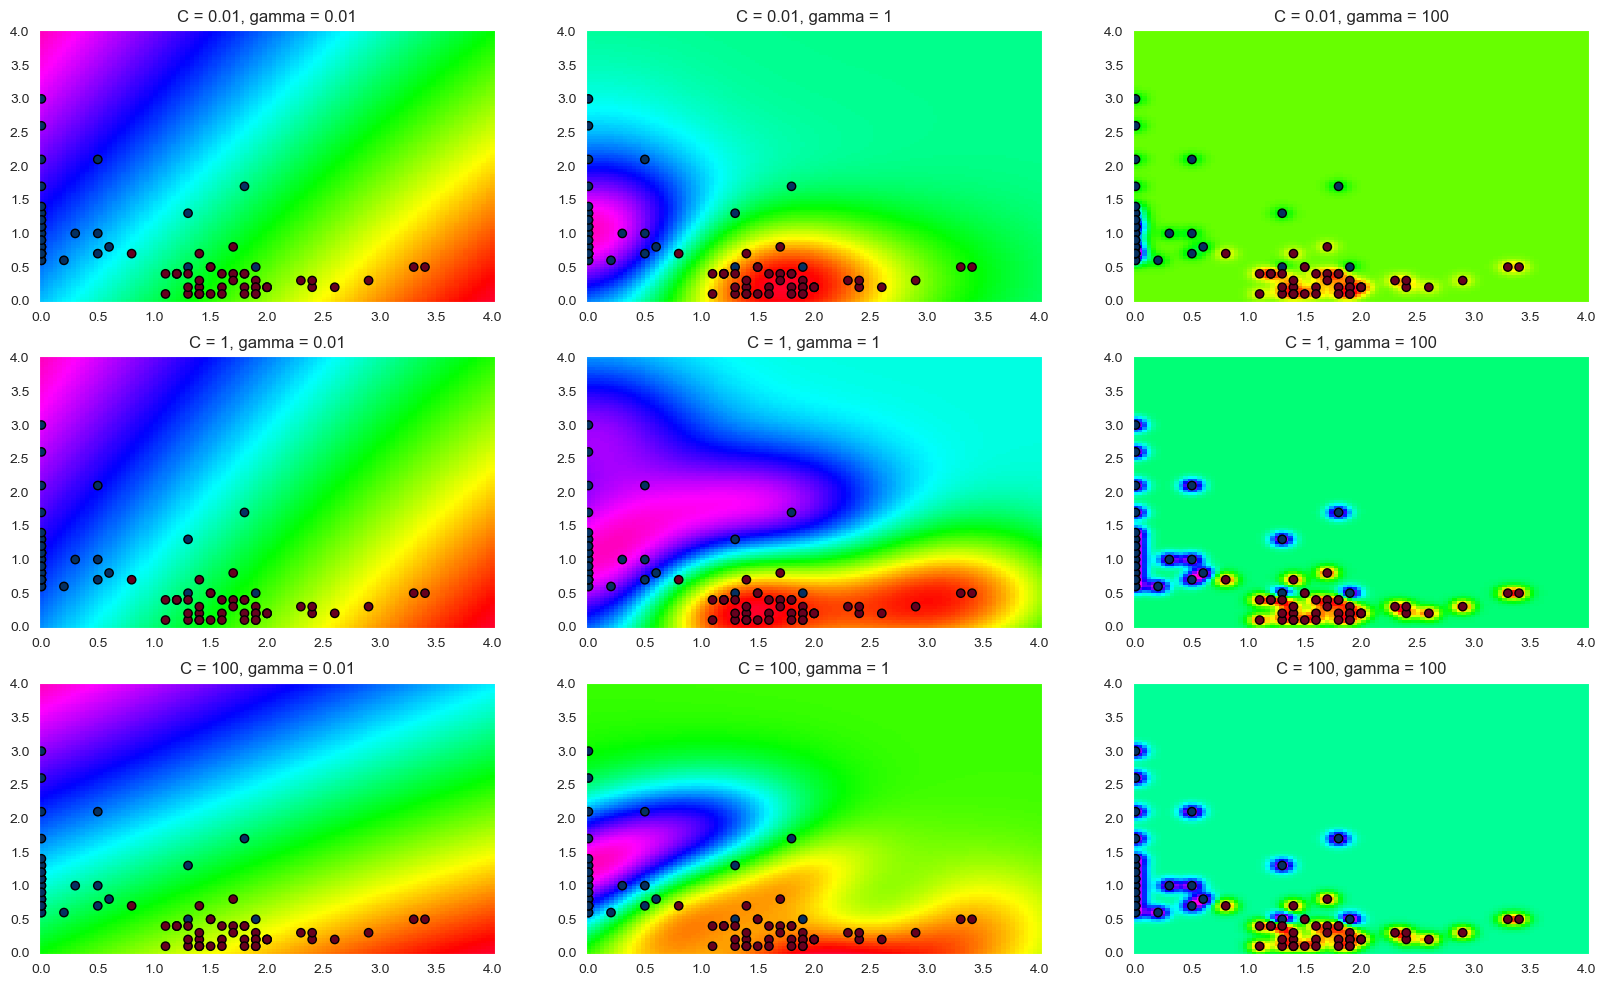

In [43]:
plt.figure(figsize=[20, 12])
# np.linspace(0, 4, 100): 0 ~ 4를 100단계로 나눈 값을 저장하는 numpy 배열을 만든다.
# print(np.linspace(0, 4, 100))
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100))

for i, (C, gamma, clf) in enumerate(classifiers):
    # print(i, (C, gamma, clf))

    # numpy 배열을 옆으로, 위아래로 붙이기: np.r_(), np.c_()
    # np.r_([a, b]) → a, b numpy 배열을 왼쪽에서 오른쪽으로 붙인다.
    # np.r_([[a, b]]) → a, b numpy 배열을 윗쪽에서 아랫쪽으로 붙인다.
    # np.c_([a, b]) → 두 개의 1차원 배열을 컬럼으로 세로로 붙여서 2차원 배열을 만든다.
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # subplot 그래프: 두 개 이상의 그래프의 상관 관계를 효과적으로 표시할 수 있다.
    # subplot을 사용하는 방법은 subplot() 메서드를 사용해서 그래프의 위치를 정해주고 그래프는 plot() 메서드로 그리면 된다.
    plt.subplot(len(C_candidates), len(gamma_candidates), i + 1)
    plt.title(f'C = {C}, gamma = {gamma}')

    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.gist_rainbow)
    plt.scatter(x=x_train['3P'], y=x_train['BLK'], c=position, edgecolors='k', cmap=plt.cm.RdBu_r)

위의 9개의 차트 중에서 정 가운데 차트가 GridSearchCV 메서드를 통해 얻은 C와 gamma를 사용해 학습한 SVM 모델이며 균등하게 두 그룹으로 분류된 것을 확인할 수 있다.
결과 차트에서 왼쪽에서 오른쪽으로 보면 gamma의 크기에 따른 결정 경계의 곡률 변화를 확인할 수 있고 위에서 아래로 보면 C의 크기에 따른 결정 경계의 위치 변화를 확인할 수 있다.

모델 테스트

In [40]:
x_test = test[['3P', 'BLK']]
y_test = test['Pos']
# 최적의 파라미터로 학습된 모델로 테스트를 진행한다.
predict = clf.predict(x_test)
print(f'정확도: {accuracy_score(y_test.values.ravel(), predict)}')

정확도: 0.8


In [41]:
print(classification_report(y_test.values.ravel(), predict))

              precision    recall  f1-score   support

           C       1.00      0.67      0.80        12
          SG       0.67      1.00      0.80         8

    accuracy                           0.80        20
   macro avg       0.83      0.83      0.80        20
weighted avg       0.87      0.80      0.80        20

